In [1]:
import numpy as np
import pandas as pd
import json
from pprint import pp
import tldextract
from scipy import stats

from retrieval_importance import split, learn_importance, encode_retrievals, encode_groups, grouped_weights, \
    most_important_groups, least_important_groups, retrievals_from_json, evaluate, evaluate_pruned, \
    tune_pruning_threshold

np.random.seed(7334)

In [2]:
relation = 'director'

retrievals = retrievals_from_json(f'./applications/question_answering/wikifact__{relation}.jsonl')

In [3]:
pp(retrievals[0], width=100, compact=True)

{'question': 'The director of Disparaît, v is',
 'correct_answers': ['Andrei Severny'],
 'retrieved_answers': ['Andrei Severny', 'Andrei Severny', 'Andrei Severny', 'Auraeus Solito',
                       'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito',
                       'Auraeus Solito.', 'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito',
                       'Auraeus Solito', 'Auraeus Solito', 'Aureaus Solito.', 'Aureaus Solito',
                       'Auraeus Solito', 'Auraeus Solito', 'Aureaus Solito', 'Aureaus Solito.',
                       'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito', 'Auraeus Solito',
                       'Aureaus Solito', 'Auraeus Solito', 'Aureaus Solito', 'Auraeus Solito',
                       'Auraeus Solito', 'Aureaus Solito', 'Auraeus Solito', 'Aureaus Solito',
                       'Jacques Feyder.', 'Aureaus Solito', 'Aureaus Solito', 'Auraeus Solito',
                       'Jacques Feyder.', 'Auraeus So

In [4]:
validation, test = split(retrievals, 0.5)

In [5]:
def utility(retrieved, prediction):
    if prediction in retrieved["correct_answers"]:
        return 1.0
    else:
        return 0.0
    
def group(retrieved):    
    url_parts = tldextract.extract(retrieved)
    return f'{url_parts.domain}.{url_parts.suffix}'    

In [6]:
encoded_retrievals, mapping = encode_retrievals(validation, "retrieved_websites", "retrieved_answers", utility)
grouping, group_mapping = encode_groups(mapping, group)

k = 10

weights = learn_importance(encoded_retrievals, k=k, learning_rate=10, num_steps=100, n_jobs=-1, grouping=grouping)
domain_weights = grouped_weights(weights, grouping, group_mapping)

In [7]:
most_important_groups(domain_weights, 5)

[('alchetron.com', 1.0),
 ('allmovie.com', 1.0),
 ('azmovies.net', 1.0),
 ('bharatpedia.org', 1.0),
 ('everipedia.org', 1.0)]

In [8]:
least_important_groups(domain_weights, 5)

[('avclub.com', 0.0),
 ('goodreads.com', 0.0),
 ('kinorium.com', 0.0),
 ('reddit.com', 0.0),
 ('theguardian.com', 0.0)]

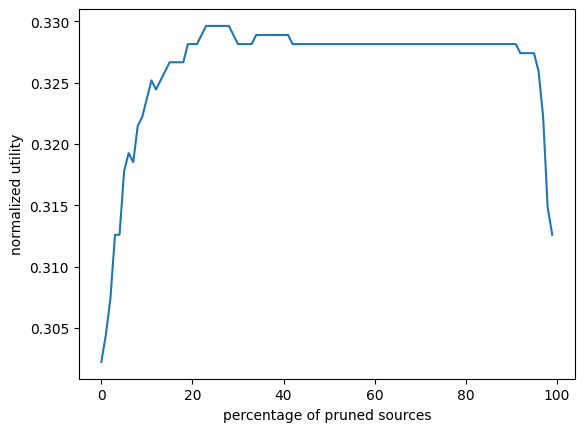

Found best (normalized) utility of 0.3296296296296296 on validation set with threshold 0.4996988715716625, removing 28 percent of domains


In [12]:
import matplotlib.pyplot as plt

percentile_range = range(0, 100, 1)

tuning_result = tune_pruning_threshold(validation, domain_weights, percentile_range, utility, k, normalize=True)

plt.plot(percentile_range, tuning_result.achieved_utilities)     
plt.ylabel('normalized utility')
plt.xlabel('percentage of pruned sources')
plt.show()
        
print(f'Found best (normalized) utility of {tuning_result.best_utility} on validation set ' +
      f'with threshold {tuning_result.best_threshold}, ' + 
      f'removing {tuning_result.best_percentile} percent of domains')        

In [13]:
evaluate(test, utility, k, normalize=True)

0.29259259259259257

In [14]:
evaluate_pruned(test, utility, k, tuning_result.best_threshold, domain_weights, normalize=True)

0.30592592592592593